In [ ]:
from pathlib import Path
import urllib.request
import tarfile
target_folder = Path("/content/drive/MyDrive/Dog_Classifier/Dataset")
target_folder.mkdir(parents=True, exist_ok=True)
tar_path = target_folder / "images.tar"
url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
if not tar_path.exists():
    print("Downloading...")
    urllib.request.urlretrieve(url, tar_path)
    print("Download completed.")
print("Extracting...")
with tarfile.open(tar_path, "r") as tar:
    tar.extractall(path=target_folder)
print("Extraction completed.")


Downloading...
Download completed.
Extracting...
Extraction completed.


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/Dog_Classifier/Dataset/Images"
IMG_SIZE = (331, 331)
BATCH_SIZE = 128

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
print("Number of classes:", NUM_CLASSES)


Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Number of classes: 120


In [ ]:
base_model = NASNetLarge(include_top=False,weights='imagenet',input_shape=(331, 331, 3))
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False
x = base_model.output
x = Flatten()(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model1 = Model(inputs=base_model.input, outputs=output)
model1.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
model1.summary()

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 331, 331,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 165, 165,  │      2,592 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 165, 165,  │        384 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 165, 165,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 165, 165,  │      4,032 │ activation[0][0]  │
│ (Conv2D)            │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 165, 165,  │        168 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 165, 165,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 165, 165,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 169, 169,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 171, 171,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 83, 83,    │      2,814 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 83, 83,    │      8,736 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 83, 83,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 83, 83,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 83, 83,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 83, 83,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 83, 83,    │      2,814 │ activation_2[0][

 Total params: 143,461,578 (547.26 MB)

 Trainable params: 68,599,224 (261.69 MB)

 Non-trainable params: 74,862,354 (285.58 MB)

In [ ]:
base_model = NASNetLarge(include_top=False,weights='imagenet',input_shape=(331, 331, 3))
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model2 = Model(inputs=base_model.input, outputs=output)
model2.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 331, 331,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 165, 165,  │      2,592 │ input_layer_1[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 165, 165,  │        384 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_260      │ (None, 165, 165,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 165, 165,  │      4,032 │ activation_260[0… │
│ (Conv2D)            │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 165, 165,  │        168 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_261      │ (None, 165, 165,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_263      │ (None, 165, 165,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 169, 169,  │          0 │ activation_261[0… │
│ (ZeroPadding2D)     │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 171, 171,  │          0 │ activation_263[0… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 83, 83,    │      2,814 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 83, 83,    │      8,736 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 83, 83,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 83, 83,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_262      │ (None, 83, 83,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_264      │ (None, 83, 83,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 83, 83,    │      2,814 │ activation_262[0

 Total params: 85,400,778 (325.78 MB)

 Trainable params: 10,538,424 (40.20 MB)

 Non-trainable params: 74,862,354 (285.58 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
models = [model1, model2]
model_labels = ['NASNet with Flatten', 'NASNet with GlobalAvgPool']
model_filenames = ['nasnet_flatten_best_model.h5', 'nasnet_globalavgpool_best_model.h5']
histories = {}
for i, model in enumerate(models):
    print(f"\nTraining Model: {model_labels[i]}")
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        ModelCheckpoint(
            filepath=f'/content/drive/MyDrive/Dog_Classifier/Models/{model_filenames[i]}',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            verbose=1,
            min_lr=1e-6
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        )
    ]
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=40,
        callbacks=callbacks,
        verbose=1
    )
    histories[model_labels[i]] = history


Training Model: NASNet with Flatten


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7996 - loss: 1.0014

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.90766, saving model to /content/drive/MyDrive/Dog_Classifier/Models/nasnet_flatten_best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 725s 5s/step - accuracy: 0.8002 - loss: 0.9980 - val_accuracy: 0.9077 - val_loss: 0.3814 - learning_rate: 1.0000e-04
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9587 - loss: 0.1376
Epoch 2: val_accuracy did not improve from 0.90766
129/129 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.9586 - loss: 0.1377 - val_accuracy: 0.9003 - val_loss: 0.4021 - learning_rate: 1.0000e-04
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9736 - loss: 0.0923
Epoch 3: val_accuracy improved from 0.90766 to 0.91257, saving model to /content/drive/MyDrive/Dog_Classifier/Models/nasnet_flatten_best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 506s 4s/step - accuracy: 0.9736 - loss: 0.0923 - val_accuracy: 0.9126 - val_loss: 0.3778 - learning_rate: 1.0000e-04
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9840 - loss: 0.0564
Epoch 4: val_accuracy did not improve from 0.91257
129/129 ━━━━━━━━━━━━━━━━━━━━ 516s 4s/step - accuracy: 0.9840 - loss: 0.0564 - val_accuracy: 0.9106 - val_loss: 0.4337 - learning_rate: 1.0000e-04
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9884 - loss: 0.0421
Epoch 5: val_accuracy did not improve from 0.91257
129/129 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - accuracy: 0.9884 - loss: 0.0421 - val_accuracy: 0.9082 - val_loss: 0.4270 - learning_rate: 1.0000e-04
Epoch 6/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9904 - loss: 0.0341
Epoch 6: val_accuracy improved from 0.91257 to 0.91503, saving model to /content/drive/MyDrive/Dog_Classifier/Models/nasnet_flatten_best_model.h5



Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
129/129 ━━━━━━━━━━━━━━━━━━━━ 504s 4s/step - accuracy: 0.9904 - loss: 0.0341 - val_accuracy: 0.9150 - val_loss: 0.4138 - learning_rate: 1.0000e-04
Epoch 7/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9948 - loss: 0.0217
Epoch 7: val_accuracy improved from 0.91503 to 0.91626, saving model to /content/drive/MyDrive/Dog_Classifier/Models/nasnet_flatten_best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 533s 4s/step - accuracy: 0.9948 - loss: 0.0217 - val_accuracy: 0.9163 - val_loss: 0.4145 - learning_rate: 1.0000e-05
Epoch 8/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9939 - loss: 0.0221
Epoch 8: val_accuracy improved from 0.91626 to 0.91724, saving model to /content/drive/MyDrive/Dog_Classifier/Models/nasnet_flatten_best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 524s 4s/step - accuracy: 0.9940 - loss: 0.0221 - val_accuracy: 0.9172 - val_loss: 0.4054 - learning_rate: 1.0000e-05
Epoch 9/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9954 - loss: 0.0170
Epoch 9: val_accuracy improved from 0.91724 to 0.92092, saving model to /content/drive/MyDrive/Dog_Classifier/Models/nasnet_flatten_best_model.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 1e-06.
129/129 ━━━━━━━━━━━━━━━━━━━━ 526s 4s/step - accuracy: 0.9954 - loss: 0.0170 - val_accuracy: 0.9209 - val_loss: 0.4062 - learning_rate: 1.0000e-05
Epoch 10/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9951 - loss: 0.0186
Epoch 10: val_accuracy did not improve from 0.92092
129/129 ━━━━━━━━━━━━━━━━━━━━ 513s 4s/step - accuracy: 0.9951 - loss: 0.0185 - val_accuracy: 0.9185 - val_loss: 0.4039 - learning_rate: 1.0000e-06
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 3.

Training Model: NASNet with GlobalAvgPool
Epoch 1/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6877 - loss: 2.3469
Epoch 1: val_accuracy improved from -inf to 0.92608, saving model to /content/drive/MyDrive/Dog_Classifier/Models/nasnet_globalavgpool_best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 593s 4s/step - accuracy: 0.6890 - loss: 2.3372 - val_accuracy: 0.9261 - val_loss: 0.2621 - learning_rate: 1.0000e-04
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9412 - loss: 0.2081
Epoch 2: val_accuracy improved from 0.92608 to 0.93124, saving model to /content/drive/MyDrive/Dog_Classifier/Models/nasnet_globalavgpool_best_model.h5


129/129 ━━━━━━━━━━━━━━━━━━━━ 502s 4s/step - accuracy: 0.9412 - loss: 0.2081 - val_accuracy: 0.9312 - val_loss: 0.2529 - learning_rate: 1.0000e-04
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9470 - loss: 0.1654
Epoch 3: val_accuracy did not improve from 0.93124
129/129 ━━━━━━━━━━━━━━━━━━━━ 497s 4s/step - accuracy: 0.9470 - loss: 0.1654 - val_accuracy: 0.9276 - val_loss: 0.2647 - learning_rate: 1.0000e-04
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9541 - loss: 0.1414
Epoch 4: val_accuracy did not improve from 0.93124
129/129 ━━━━━━━━━━━━━━━━━━━━ 493s 4s/step - accuracy: 0.9541 - loss: 0.1415 - val_accuracy: 0.9239 - val_loss: 0.2652 - learning_rate: 1.0000e-04
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9594 - loss: 0.1211
Epoch 5: val_accuracy did not improve from 0.93124

Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
129/129 ━━━━━━━━━━━━━━━━━━━━ 493s 4s/step - accuracy: 0.9594 - loss: 0.1211 -

129/129 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.9696 - loss: 0.0893 - val_accuracy: 0.9354 - val_loss: 0.2614 - learning_rate: 1.0000e-06
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 2.


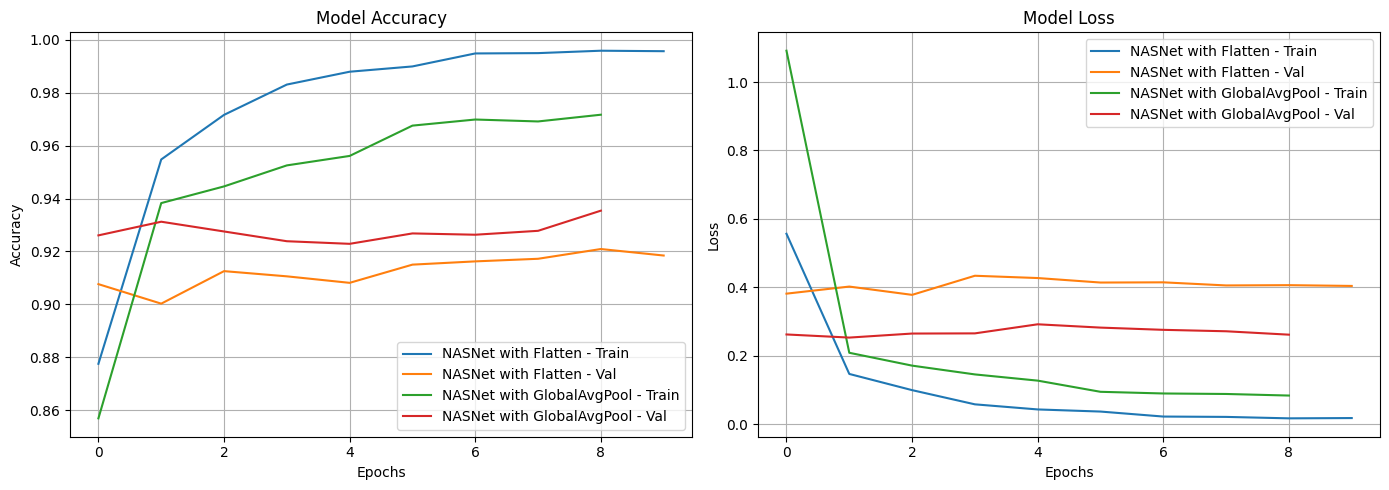

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
for label, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{label} - Train')
    plt.plot(history.history['val_accuracy'], label=f'{label} - Val')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
for label, history in histories.items():
    plt.plot(history.history['loss'], label=f'{label} - Train')
    plt.plot(history.history['val_loss'], label=f'{label} - Val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model1 = load_model('/content/drive/MyDrive/Dog_Classifier/Models/nasnet_flatten_best_model.h5')
model2 = load_model('/content/drive/MyDrive/Dog_Classifier/Models/nasnet_globalavgpool_best_model.h5')

In [ ]:
val_loss_1, val_acc_1 = model1.evaluate(val_generator)
print(f"Model 1 (NASNet + Flatten) - Val Loss: {val_loss_1:.4f}, Val Accuracy: {val_acc_1:.4f}")

val_loss_2, val_acc_2 = model2.evaluate(val_generator)
print(f"Model 2 (NASNet + GlobalAvgPool) - Val Loss: {val_loss_2:.4f}, Val Accuracy: {val_acc_2:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1891s 59s/step - accuracy: 0.9188 - loss: 0.4051
Model 1 (NASNet + Flatten) - Val Loss: 0.4173, Val Accuracy: 0.9158
32/32 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.9358 - loss: 0.2428
Model 2 (NASNet + GlobalAvgPool) - Val Loss: 0.2630, Val Accuracy: 0.9278


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
y_true = val_generator.classes
y_pred_probs_1 = model1.predict(val_generator, verbose=1)
y_pred_1 = np.argmax(y_pred_probs_1, axis=1)
val_loss_1, val_acc_1 = model1.evaluate(val_generator, verbose=1)
print(f"\nModel 1 (NASNet + Flatten) - Val Loss: {val_loss_1:.4f}, Val Accuracy: {val_acc_1:.4f}")
print("Classification Report (Model 1):")
print(classification_report(y_true, y_pred_1, digits=4))
print(f"Weighted F1 Score: {f1_score(y_true, y_pred_1, average='weighted'):.4f}")
print(f"Weighted Precision: {precision_score(y_true, y_pred_1, average='weighted'):.4f}")
print(f"Weighted Recall: {recall_score(y_true, y_pred_1, average='weighted'):.4f}")
y_pred_probs_2 = model2.predict(val_generator, verbose=1)
y_pred_2 = np.argmax(y_pred_probs_2, axis=1)
val_loss_2, val_acc_2 = model2.evaluate(val_generator, verbose=1)
print(f"\nModel 2 (NASNet + GlobalAvgPool) - Val Loss: {val_loss_2:.4f}, Val Accuracy: {val_acc_2:.4f}")
print("Classification Report (Model 2):")
print(classification_report(y_true, y_pred_2, digits=4))
print(f"Weighted F1 Score: {f1_score(y_true, y_pred_2, average='weighted'):.4f}")
print(f"Weighted Precision: {precision_score(y_true, y_pred_2, average='weighted'):.4f}")
print(f"Weighted Recall: {recall_score(y_true, y_pred_2, average='weighted'):.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9188 - loss: 0.3852

Model 1 (NASNet + Flatten) - Val Loss: 0.4084, Val Accuracy: 0.9160
Classification Report (Model 1):
              precision    recall  f1-score   support

           0     0.8286    0.9667    0.8923        30
           1     0.9000    0.9730    0.9351        37
           2     0.9412    0.9600    0.9505        50
           3     0.9310    0.9310    0.9310        29
           4     0.7660    0.8571    0.8090        42
           5     0.9722    0.9459    0.9589        37
           6     1.0000    0.9744    0.9870        39
           7     0.9091    0.8824    0.8955        34
           8     0.9394    0.9118    0.9254        34
           9     0.9388    0.9787    0.9583        47
          10     0.9444    0.9714    0.9577        35
          11     0.9286    1.0000    0.9630        39
          12     0.9024    1.0000    0.9487        37
          13     1.0000    0

32/32 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step
Classification Report for Model 1 (NASNet + Flatten):
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.83      0.97      0.89        30
              n02085782-Japanese_spaniel       0.90      0.97      0.94        37
                   n02085936-Maltese_dog       0.90      0.92      0.91        50
                      n02086079-Pekinese       0.93      0.93      0.93        29
                      n02086240-Shih-Tzu       0.82      0.86      0.84        42
              n02086646-Blenheim_spaniel       1.00      0.89      0.94        37
                      n02086910-papillon       1.00      0.95      0.97        39
                   n02087046-toy_terrier       0.89      0.94      0.91        34
           n02087394-Rhodesian_ridgeback       0.85      0.82      0.84        34
                  n02088094-Afghan_hound       0.98      1.00      0.99        47
    

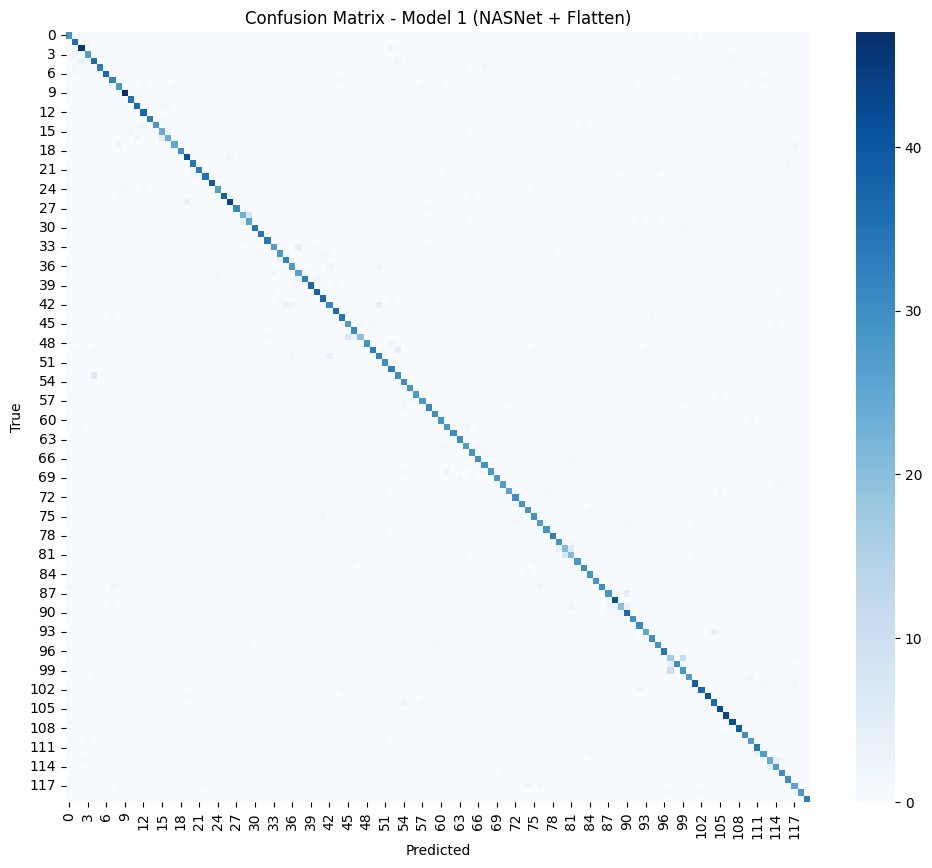

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Predict on validation set
Y_pred = model1.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# === Classification report
print("Classification Report for Model 1 (NASNet + Flatten):")
print(classification_report(y_true, y_pred, target_names=class_labels))

# === Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# === Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix - Model 1 (NASNet + Flatten)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step
Classification Report for Model 2 (NASNet + GlobalAvgPool):
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.94      1.00      0.97        30
              n02085782-Japanese_spaniel       0.92      0.97      0.95        37
                   n02085936-Maltese_dog       0.92      0.94      0.93        50
                      n02086079-Pekinese       0.90      0.93      0.92        29
                      n02086240-Shih-Tzu       0.82      0.86      0.84        42
              n02086646-Blenheim_spaniel       1.00      1.00      1.00        37
                      n02086910-papillon       1.00      0.97      0.99        39
                   n02087046-toy_terrier       0.92      0.97      0.94        34
           n02087394-Rhodesian_ridgeback       0.83      0.85      0.84        34
                  n02088094-Afghan_hound       1.00      0.98      0.99        4

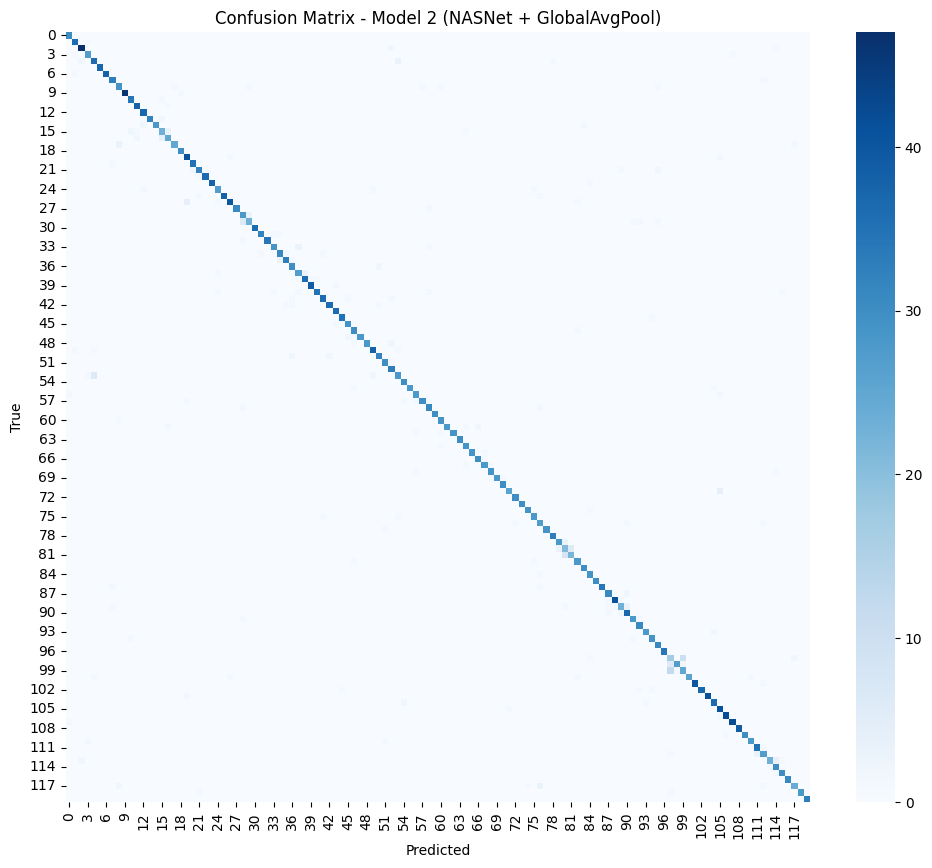

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Predict on validation set
Y_pred = model2.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# === Classification report
print("Classification Report for Model 2 (NASNet + GlobalAvgPool):")
print(classification_report(y_true, y_pred, target_names=class_labels))

# === Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# === Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix - Model 2 (NASNet + GlobalAvgPool)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from pathlib import Path
path1 = Path('/content/drive/MyDrive/Dog_Classifier/Models/nasnet_flatten_best_model.h5')
path2 = Path('/content/drive/MyDrive/Dog_Classifier/Models/nasnet_globalavgpool_best_model.h5')
size1 = path1.stat().st_size / (1024 * 1024)
size2 = path2.stat().st_size / (1024 * 1024)
print(f"NASNetLarge with Flatten() layer model size: {size1:.2f} MB")
print(f"NASNetLarge with GlobalAveragePooling2D() layer model size: {size2:.2f} MB")


NASNetLarge with Flatten() layer model size: 1075.35 MB
NASNetLarge with GlobalAveragePooling2D() layer model size: 410.90 MB


In [ ]:
from pathlib import Path
temp_path=Path("/content/drive/MyDrive/Dog_Classifier/Dataset/Images")
l = list(temp_path.glob("*"))

In [ ]:
l

[PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02085620-Chihuahua'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02085782-Japanese_spaniel'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02085936-Maltese_dog'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02086079-Pekinese'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02086240-Shih-Tzu'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02086646-Blenheim_spaniel'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02086910-papillon'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02087046-toy_terrier'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02087394-Rhodesian_ridgeback'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02088094-Afghan_hound'),
 PosixPath('/content/drive/MyDrive/Dog_Classifier/Dataset/Images/n02088238-basset'),
 PosixP

In [ ]:
dog=[x.stem for x in l]

In [ ]:
from natsort import natsorted
dogsorted=natsorted(dog)

In [ ]:
dogsorted

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi